# Time Series Dataset Classification 
dataset: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('datatraining.txt')
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


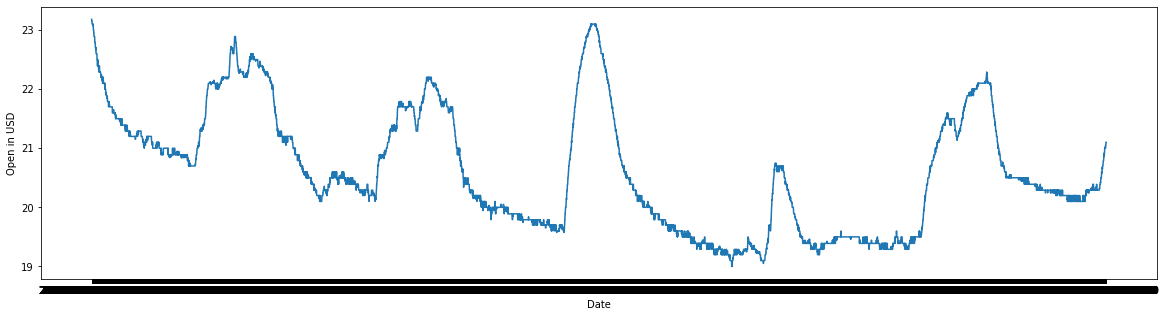

In [ ]:
#Plot data
X = df['date'].values
y = df['Temperature'].values

plt.figure(figsize=(20,5))
plt.xlabel('Date')
plt.ylabel('Open in USD')
plt.plot(X, y)
plt.show()

In [ ]:
#Split data train dan tes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#Fungsi merubah data menjadi bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(y_train,
                             window_size=60,
                             batch_size=100,
                             shuffle_buffer=1000)

val_test = windowed_dataset(y_test,
                            window_size=60,
                            batch_size=100,
                            shuffle_buffer=1000)

model = tf.keras.models.Sequential([
                                    LSTM(64, return_sequences=True),
                                    LSTM(64),
                                    Dense(32, activation='relu'),
                                    Dense(16, activation='relu'),
                                    Dense(1)
])

In [ ]:
#Class callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae')<5.0) & (logs.get('val_mae')<5.0)):
      print("\nError training dan validasi telah mencapai <5!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_test,
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
65/65 [==============================] - 5s 31ms/step - loss: 19.9052 - mae: 20.4052 - val_loss: 19.7710 - val_mae: 20.2710
Epoch 2/100
65/65 [==============================] - 1s 21ms/step - loss: 19.5438 - mae: 20.0438 - val_loss: 19.2880 - val_mae: 19.7880
Epoch 3/100
65/65 [==============================] - 1s 21ms/step - loss: 18.9450 - mae: 19.4450 - val_loss: 18.5384 - val_mae: 19.0384
Epoch 4/100
65/65 [==============================] - 1s 21ms/step - loss: 17.9152 - mae: 18.4152 - val_loss: 17.0886 - val_mae: 17.5886
Epoch 5/100
65/65 [==============================] - 1s 21ms/step - loss: 15.6135 - mae: 16.1135 - val_loss: 13.4335 - val_mae: 13.9335
Epoch 6/100
65/65 [==============================] - 1s 21ms/step - loss: 8.4711 - mae: 8.9672 - val_loss: 0.4767 - val_mae: 0.8569
Epoch 7/100
65/65 [==============================] - 1s 21ms/step - loss: 0.5365 - mae: 0.9365 - val_loss: 0.4577 - val_mae: 0.8442

Error training dan validasi telah mencapai <5!


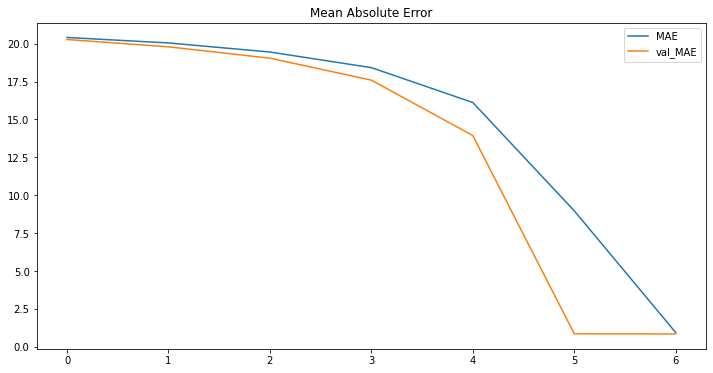

In [ ]:
#Plot hasil dari error yang dihasilkan
plt.figure(figsize=(12,6))

plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='val_MAE')
plt.title('Mean Absolute Error')
plt.legend()


plt.show()